In [172]:
%reload_ext autoreload
%autoreload 2

In [173]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [174]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils
import seaborn as sns

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [175]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

### Loading the slack data

In [176]:
# folder where the data resides
data_folder = "../data/"
data_loader = SlackDataLoader(data_folder)
# get all channels
channels = data_loader.channels
# get all data from all channels
data_list = [ data_loader.slack_parser(data_folder+channel['name']+'/') for channel in channels ]
#Create the data from all the data list
data = pd.concat(data_list, ignore_index=True)

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17749 entries, 0 to 17748
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           17749 non-null  object
 1   msg_content        17749 non-null  object
 2   sender_name        17749 non-null  object
 3   msg_sent_time      17749 non-null  object
 4   msg_dist_type      17749 non-null  object
 5   time_thread_start  17749 non-null  object
 6   reply_count        17749 non-null  int64 
 7   reply_users_count  17749 non-null  int64 
 8   reply_users        17749 non-null  object
 9   tm_thread_end      17749 non-null  object
 10  channel            17749 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


## Pre Analsysis
### Convert from unix time to readable timestampobject for the columns msg_sent_time, time_thread_start and tm_thread_end

In [178]:
data['time_thread_start'] = utils.convert_2_timestamp('time_thread_start', data)
data['msg_sent_time'] = utils.convert_2_timestamp('msg_sent_time', data)
data['tm_thread_end'] = utils.convert_2_timestamp('tm_thread_end', data)

In [179]:
data

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,get well *Lynn*,Cynthia Davis,2022-09-05 10:03:23,text,2022-09-05 09:50:13,0,0,0,0,all-community-building
1,message,get well,Bryan Clark,2022-09-05 10:18:43,text,2022-09-05 09:50:13,0,0,0,0,all-community-building
2,message,may god be with you,Gregory Bowman,2022-09-05 10:23:37,text,2022-09-05 09:50:13,0,0,0,0,all-community-building
3,message,please be kind :grimacing:,Kenneth Williams,2022-09-05 10:35:45,text,2022-09-05 09:48:18,0,0,0,0,all-community-building
4,message,get well <@u03v1am5tfa>,Kenneth Williams,2022-09-05 10:36:21,text,2022-09-05 09:50:13,0,0,0,0,all-community-building
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,the beginning of the end:joy: :joy:,David Nguyen,2022-11-07 08:46:29,text,0,0,0,0,0,all-week12
17745,message,12 of 12:Joanne0:,Bridget Glover,2022-11-07 09:18:36,text,0,0,0,0,0,all-week12
17746,message,:timer_clock:*reminder*:timer_clock: *reminder...,Lynn Shepherd,2022-11-07 09:22:32,emoji,0,0,0,0,0,all-week12
17747,message,<https://developer.algorand.org/solutions/mint...,Dennis Parker,2022-11-13 20:06:15,link,0,0,0,0,0,all-web3-week12


## Perform EDA analysis to answer the following questions 

### Which user has the highest number of reply counts?

In [180]:
replay_count=data.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)

df_replay_count = replay_count.reset_index()

In [183]:
df_replay_count.head(10)

,sender_name,reply_count
0,Lisa Dickerson,620
1,Lynn Shepherd,462
2,Kenneth Williams,367
3,Monica Newton,307
4,Cynthia Davis,306
5,Zachary Clark,302
6,Gregory Bowman,299
7,Kelsey Shields,282
8,Jennifer Carrillo,247
9,James Mann,242


In [229]:
# Visualize reply counts per user per channel
plt.matplotlib.style.use('seaborn-dark-palette')

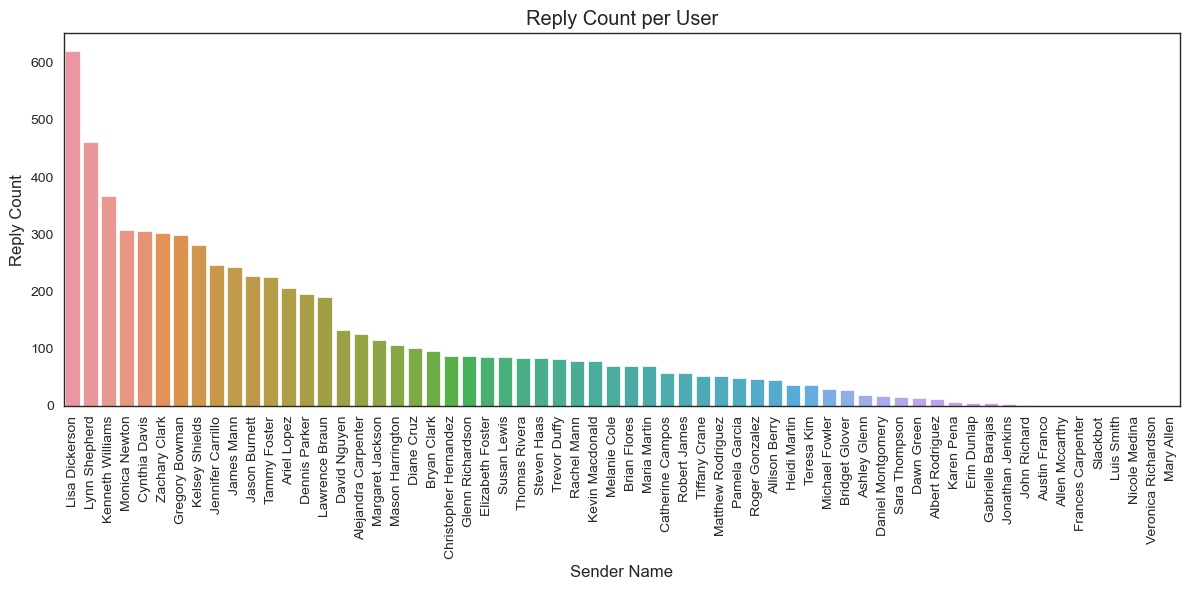

In [305]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(y= "reply_count", x = "sender_name", data = df_replay_count)
ax.tick_params(axis='x', rotation=90)
plt.xlabel('Sender Name')
plt.ylabel('Reply Count')
plt.title('Reply Count per User')
plt.tight_layout()
plt.show()

In [306]:
top_10 = df_replay_count[:10]
top_10

,sender_name,reply_count
0,Lisa Dickerson,620
1,Lynn Shepherd,462
2,Kenneth Williams,367
3,Monica Newton,307
4,Cynthia Davis,306
5,Zachary Clark,302
6,Gregory Bowman,299
7,Kelsey Shields,282
8,Jennifer Carrillo,247
9,James Mann,242


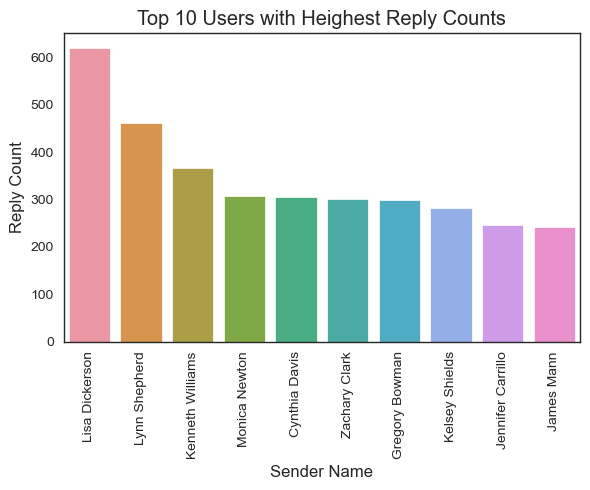

In [310]:
plt.figure(figsize=(6, 5))
ax = sns.barplot(x = "sender_name", y="reply_count", data=top_10)
plt.xlabel('Sender Name')
plt.ylabel('Reply Count')
plt.title('Top 10 Users with Heighest Reply Counts')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [334]:
channel_replay_counts=data.groupby(['sender_name','channel'])['reply_count'].sum().sort_values(ascending=False)

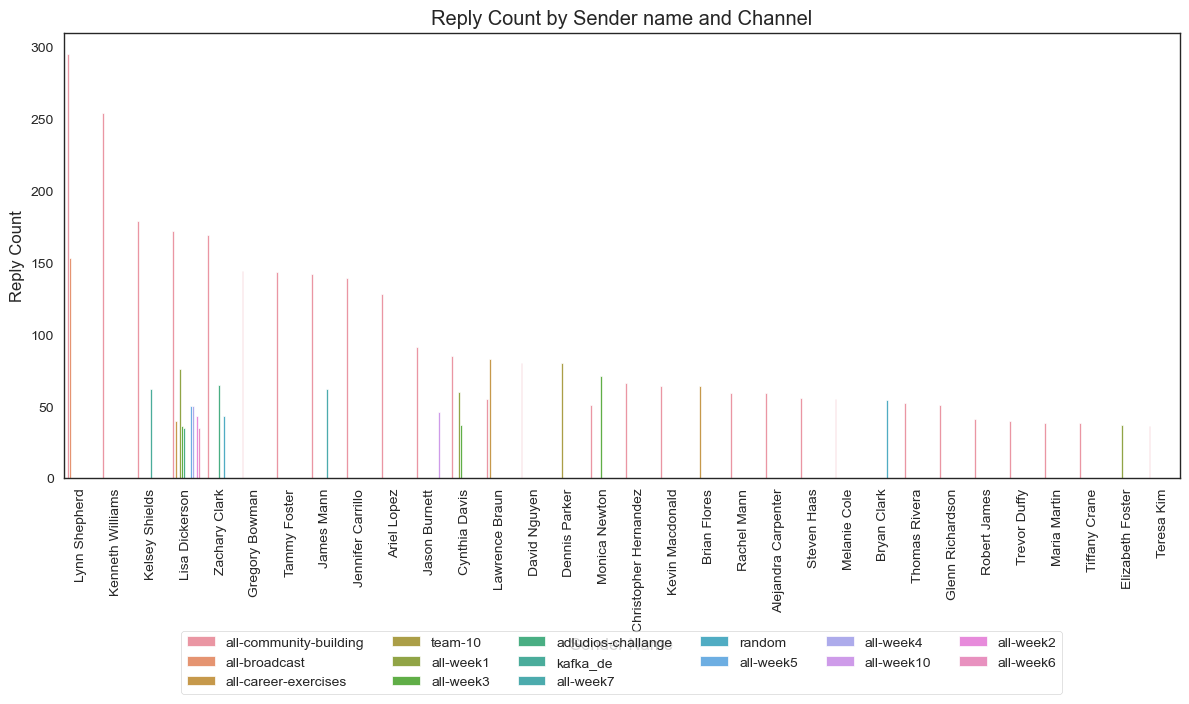

In [335]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_channel_replay_counts.head(50), x='sender_name', y='reply_count', hue='channel')
plt.title('Reply Count by Sender name and Channel')

plt.xlabel('Sender Name')
plt.ylabel('Reply Count')
ax.tick_params(axis='x', rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5)
ax.legend()

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_197618/1239178527.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x2800 with 0 Axes>

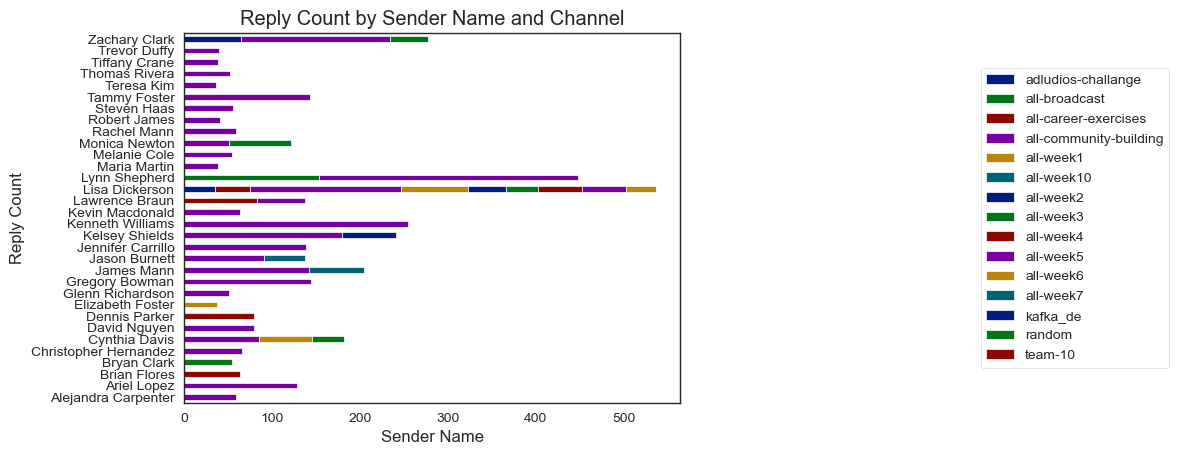

In [336]:
plt.figure(figsize=(12, 28))
pivot_data = df_channel_replay_counts.head(50).pivot(index='sender_name', columns='channel', values='reply_count')
pivot_data.plot(kind='barh', stacked=True)
plt.xlabel('Sender Name')
plt.ylabel('Reply Count')
plt.title('Reply Count by Sender Name and Channel')
plt.legend(loc='right',bbox_to_anchor=(2, 0.5))
plt.tight_layout()
plt.show()

In [337]:
top_10 = df_channel_replay_counts.head(20)
top_10

,sender_name,channel,reply_count
0,Lynn Shepherd,all-community-building,295
1,Kenneth Williams,all-community-building,254
2,Kelsey Shields,all-community-building,179
3,Lisa Dickerson,all-community-building,172
4,Zachary Clark,all-community-building,169
5,Lynn Shepherd,all-broadcast,153
6,Gregory Bowman,all-community-building,144
7,Tammy Foster,all-community-building,143
8,James Mann,all-community-building,142
9,Jennifer Carrillo,all-community-building,139


In [338]:
pivot_df = top_10.pivot_table(index='sender_name', columns='channel', values='reply_count')

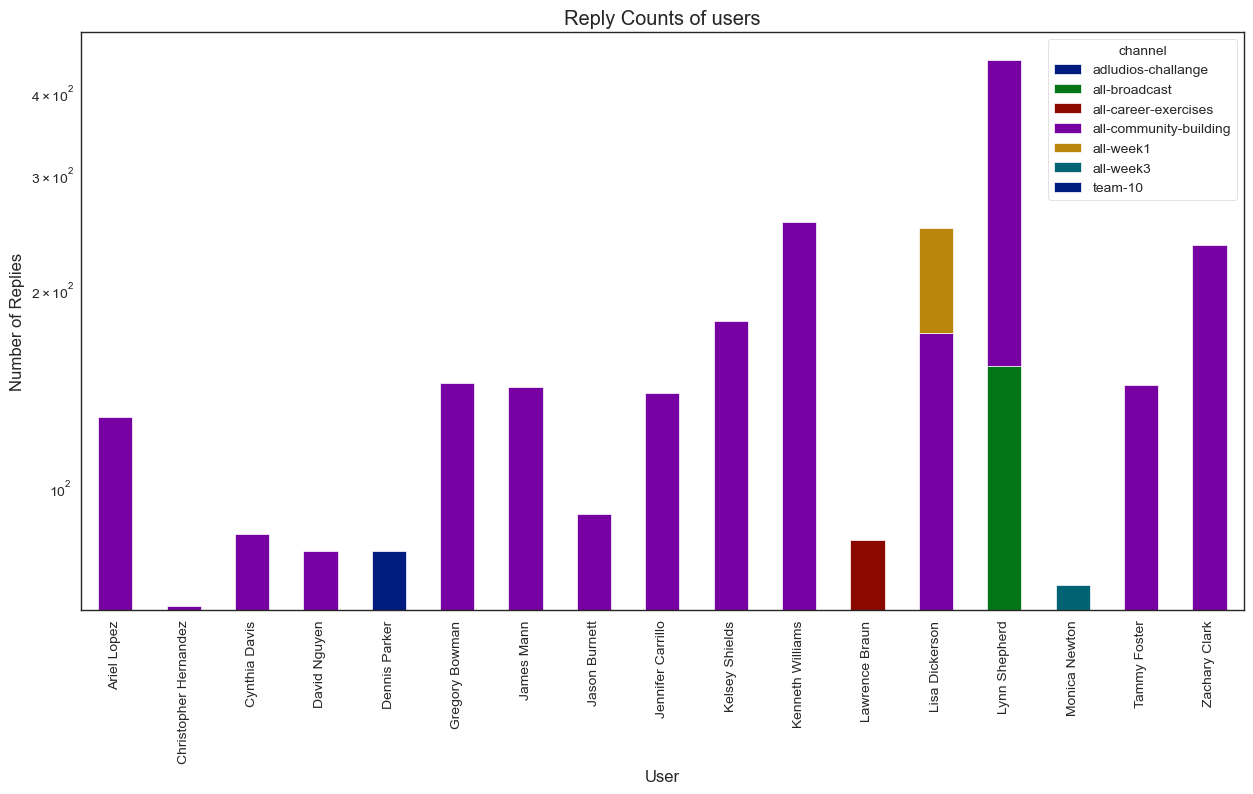

In [339]:
pivot_df.plot(kind='bar', figsize=(15, 7.5),stacked=True)
plt.yscale('log')
plt.title('Reply Counts of users')
plt.xlabel('User')
plt.ylabel('Number of Replies')
plt.show()

In [340]:
bottom_10 = df_channel_replay_counts.tail(20)
bottom_10

,sender_name,channel,reply_count
731,Mason Harrington,all-week4,0
732,Mason Harrington,all-week3,0
733,Mason Harrington,all-week11,0
734,Mason Harrington,all-week10,0
735,Dennis Parker,all-web3-week12,0
736,Dennis Parker,all-week11,0
737,Mason Harrington,all-resources,0
738,Dennis Parker,all-week3,0
739,Dennis Parker,all-week5,0
740,Mary Allen,all-community-building,0


In [341]:
pivot_df = bottom_10.pivot_table(index='sender_name', columns='channel', values='reply_count', fill_value=0)
pivot_df

channel,all-broadcast,all-career-exercises,all-community-building,all-ideas,all-resources,all-web3-week12,all-week1,all-week10,all-week11,all-week12,all-week3,all-week4,all-week5,dsa-sql,random
sender_name,,,,,,,,,,,,,,,
Albert Rodriguez,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dennis Parker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diane Cruz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Maria Martin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mary Allen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mason Harrington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


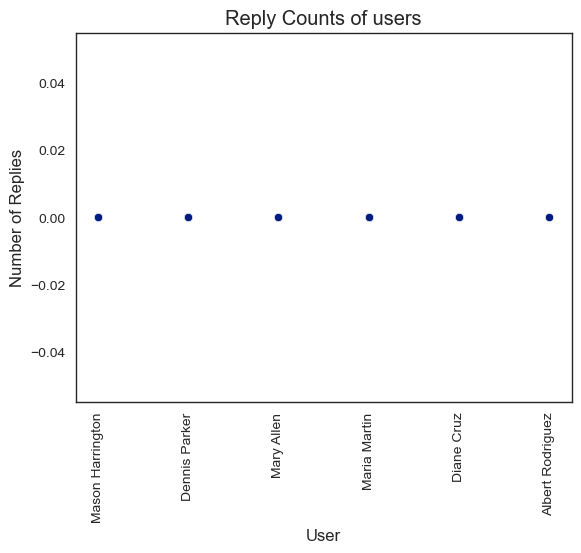

In [342]:
plt.figsize=(15, 7.5)
ax = sns.scatterplot(x = 'sender_name',y='reply_count', data = bottom_10)
ax.tick_params(axis='x', rotation=90)
#plt.yscale('log')
plt.title('Reply Counts of users')
plt.xlabel('User')
plt.ylabel('Number of Replies')
plt.show()

# Message Counts

In [343]:
users_message_count = data.groupby('sender_name').size().sort_values(ascending=False)

In [344]:
df_users_message_count = pd.DataFrame({'sender_name': users_message_count.index,\
                                      'message_count':users_message_count.values})

In [345]:
df_users_message_count

,sender_name,message_count
0,Lynn Shepherd,1288
1,Kelsey Shields,1150
2,Gregory Bowman,1075
3,Zachary Clark,991
4,Monica Newton,843
...,...,...
57,Mary Allen,1
58,Nicole Medina,1
59,Allen Mccarthy,1
60,Austin Franco,1


In [346]:
top_10_message_count = df_users_message_count.head(10)
top_10_message_count

,sender_name,message_count
0,Lynn Shepherd,1288
1,Kelsey Shields,1150
2,Gregory Bowman,1075
3,Zachary Clark,991
4,Monica Newton,843
5,Lisa Dickerson,831
6,Ariel Lopez,754
7,James Mann,641
8,Tammy Foster,574
9,Jennifer Carrillo,519


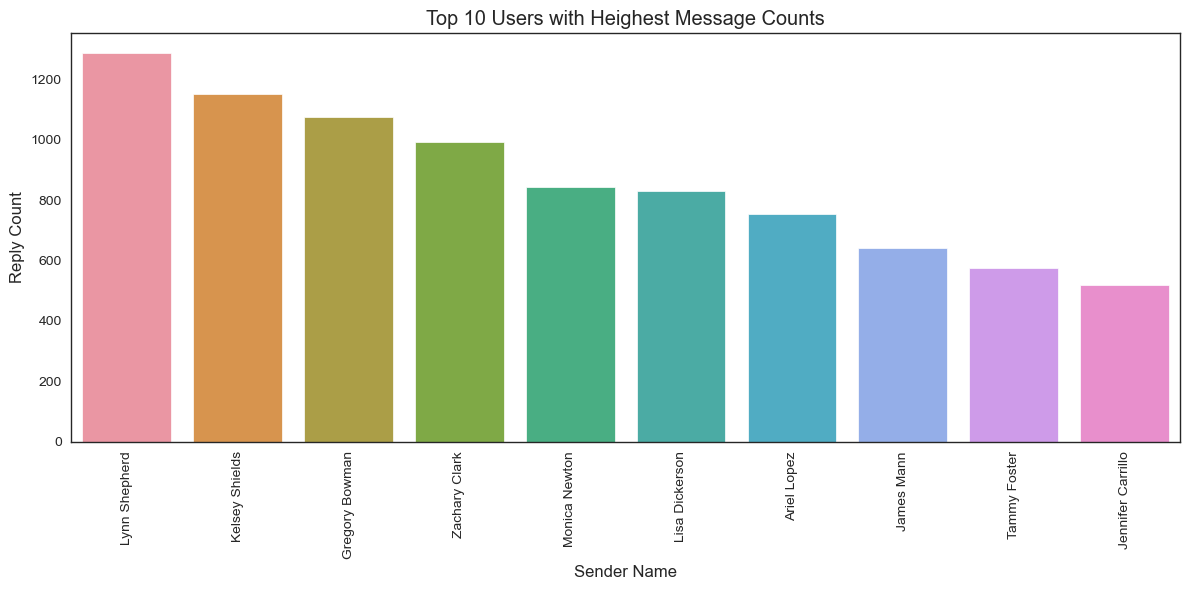

In [347]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "sender_name", y="message_count", data=top_10_message_count)
plt.xlabel('Sender Name')
plt.ylabel('Reply Count')
plt.title('Top 10 Users with Heighest Message Counts')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [348]:
bottom_10_message_count = df_users_message_count.tail(10)
bottom_10_message_count

,sender_name,message_count
52,John Richard,10
53,Luis Smith,8
54,Jonathan Jenkins,7
55,Frances Carpenter,5
56,Slackbot,3
57,Mary Allen,1
58,Nicole Medina,1
59,Allen Mccarthy,1
60,Austin Franco,1
61,Veronica Richardson,1


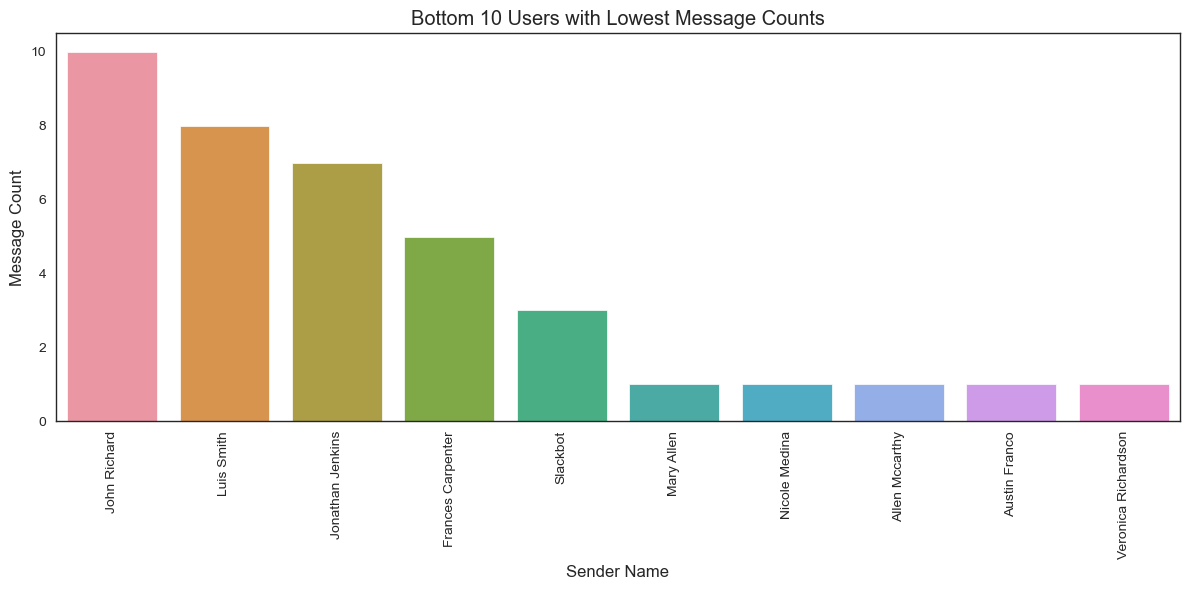

In [349]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "sender_name", y="message_count", data=bottom_10_message_count)
plt.xlabel('Sender Name')
plt.ylabel('Message Count')
plt.title('Bottom 10 Users with Lowest Message Counts')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# Reactions Counts

In [350]:
reaction_data=[]
for channel in channels:    
    reaction_data.append(data_loader.parse_slack_reaction(data_folder+channel['name']+'/',channel['name']))
    
all_reaction_data = pd.concat(reaction_data, ignore_index=True)

In [351]:
all_reaction_data

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,joy,1,U03T89ACUUW,please be kind :grimacing:,U03UJKJGRAQ,all-community-building
1,birthday,10,"U03UUR571A5,U03UDBUL7CL,U03UG1RTXAP,U03UJN29Y4...","hello community, please join me to wish our o...",U03V1AM5TFA,all-community-building
2,clap,8,"U03U9EJR362,U03UG32J3PC,U03UJGRN5E0,U03UD5B7C3...",news news *<!here>*........:drum_with_drumstic...,U03T89ACUUW,all-community-building
3,pray,2,"U03UD68RQH3,U03UG1RTXAP",congrats <@u03uup56mdf> <@u03ug0sfhgt> <@u03uv...,U03UFV7HFNF,all-community-building
4,fire,3,"U03T89ACUUW,U03UG1RTXAP,U03UVHCV6KB",karate :martial_arts_uniform:,U03U9FWPNCE,all-community-building
...,...,...,...,...,...,...
5012,smile,5,"U03V61VGQG0,U03UG1Z21JP,U03UFV7HFNF,U03V785NLS...",the beginning of the end:joy: :joy:,U03UG0YHAUT,all-week12
5013,raised_hands,6,"U03UG0YHAUT,U03UG32J3PC,U03UFV7HFNF,U03UG5VFN0...",12 of 12:Joanne0:,U03TEPYRM2P,all-week12
5014,muscle,2,"U03UG0SFHGT,U03U1FNPEUX",12 of 12:Joanne0:,U03TEPYRM2P,all-week12
5015,muscle::skin-tone-4,1,U03U1HAG9TR,12 of 12:Joanne0:,U03TEPYRM2P,all-week12


In [352]:
reaction_counts = all_reaction_data.sort_values(by='reaction_count', ascending=False)
users_reaction_count= reaction_counts[['user_id','reaction_count']]

In [353]:
users_reaction_count

,user_id,reaction_count
4684,U03TEPYRM2P,17
2305,U03U1GHT39V,16
4076,U03U93GNNVB,16
1100,U03UG0SFHGT,16
4468,U03TEPYRM2P,15
...,...,...
2174,U03UVHCV6KB,1
2176,U03UJGP0C68,1
2177,U03UJGP0C68,1
2182,U03UG1Z21JP,1


In [354]:
user_names_by_id = pd.DataFrame(list(data_loader.get_user_map()[0].items()), columns=['user_id','user_name'] )
user_names_by_id

,user_id,user_name
0,U03T89ACUUW,Rachel
1,U03TEPYRM2P,Bridget
2,U03TNP8Q8CT,Victor
3,U03TT5KEYCF,Brian
4,U03TX2VN6H5,Joanne
...,...,...
66,U03V8LHPDME,Albert
67,U03VAH809FC,Stephanie
68,U0401GU4W6L,Bonnie
69,U0418T6CD1B,Debra


In [355]:
merged_user_reactions = users_reaction_count.merge(user_names_by_id, on='user_id',how='inner')

In [356]:
merged_user_reactions = merged_user_reactions[['user_name','reaction_count']]

In [357]:
user_reactions_count = merged_user_reactions.groupby('user_name').sum()['reaction_count'].sort_values(ascending=False).reset_index()

In [358]:
user_reactions_count

,user_name,reaction_count
0,Lynn,1124
1,Zachary,625
2,Kelsey,573
3,Tammy,536
4,Lisa,509
5,James,448
6,Gregory,440
7,Ariel,428
8,Kenneth,424
9,Lawrence,383


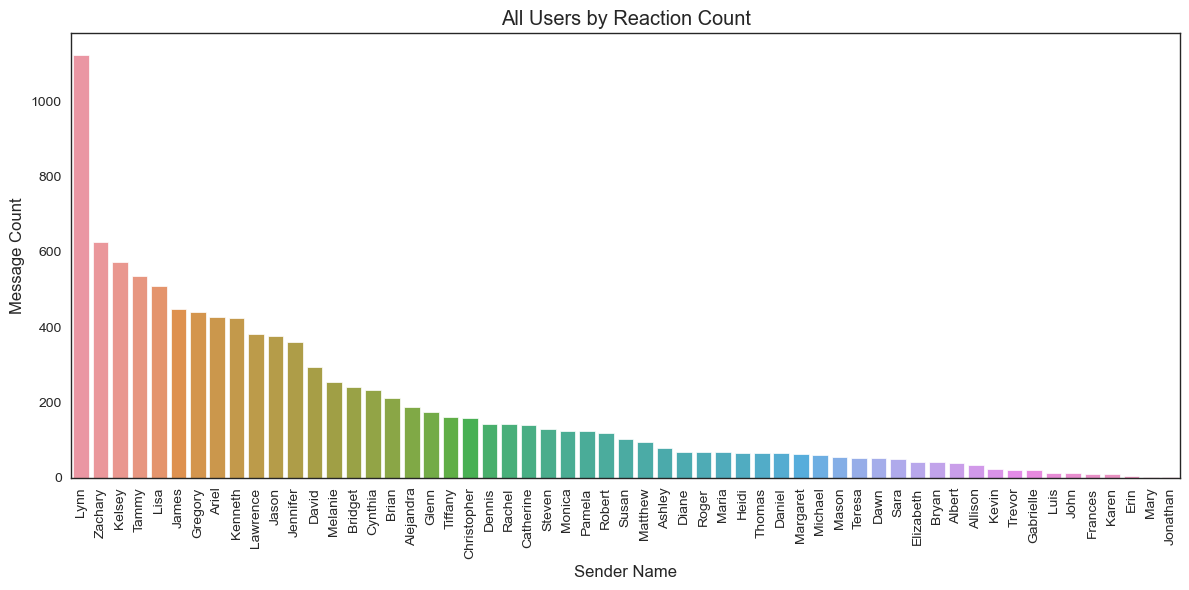

In [359]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "user_name", y="reaction_count", data=user_reactions_count)
plt.xlabel('Sender Name')
plt.ylabel('Message Count')
plt.title('All Users by Reaction Count')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

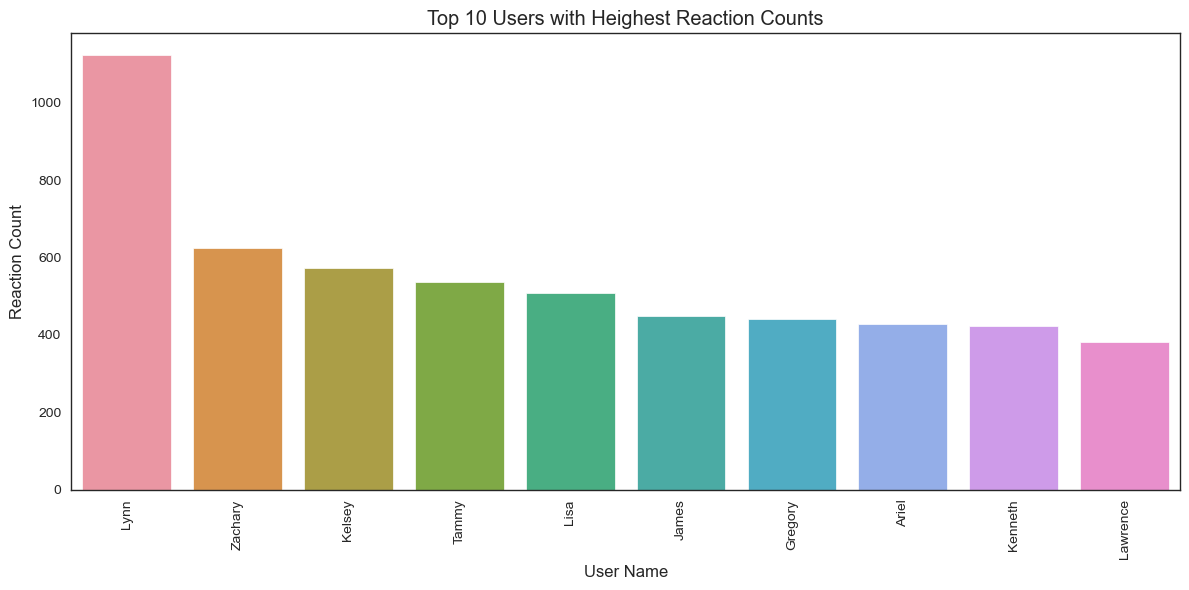

In [360]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "user_name", y="reaction_count", data=user_reactions_count.head(10))
plt.xlabel('User Name')
plt.ylabel('Reaction Count')
plt.title('Top 10 Users with Heighest Reaction Counts')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

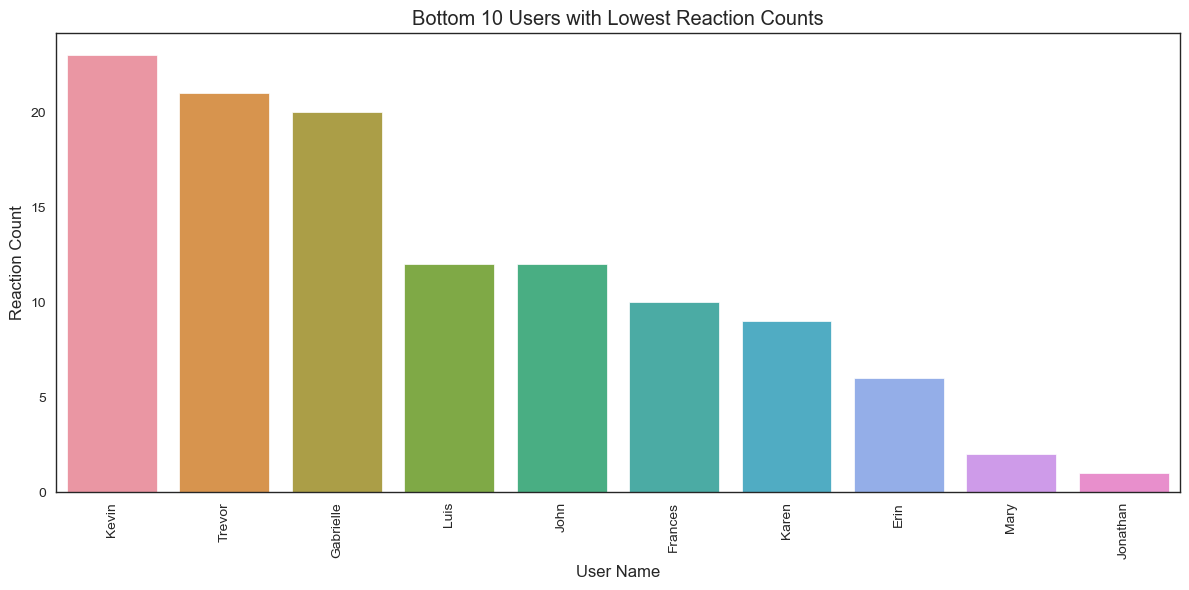

In [361]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = "user_name", y="reaction_count", data=user_reactions_count.tail(10))
plt.xlabel('User Name')
plt.ylabel('Reaction Count')
plt.title('Bottom 10 Users with Lowest Reaction Counts')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# what is the time range of the day that most messages are sent?

In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?